In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
import plotly.express as px
from docx import Document

In [2]:
def get_historical_cities(year: int, verbose: bool = False):
    """
    Retrieves the DataFrame of cities for the given year from dfs_by_year_dict.

    Args:
        year (int): The year for which to retrieve the city data.
        verbose (bool): If True, print debug information. Default is False.

    Returns:
        pandas.DataFrame: DataFrame containing city, latitude, and longitude for the given year.
    """
    if verbose:
        print("Connecting to the database...")
    # Connect to the database
    connection = sqlite3.connect('planet_fone.db')

    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()

    # Execute the query to fetch city_x, latitude, and longitude from fone_geography
    cursor.execute("SELECT  fg.city_x, fg.latitude, fg.longitude \
                    FROM fone_calendar fc \
                    LEFT JOIN fone_geography fg ON fc.geo_id = fg.id \
                    WHERE fc.year = ?", (year,))

    # Fetch all results
    city_data = cursor.fetchall()

    # Close the connection
    connection.close()
    if verbose:
        print("Database connection closed.")
    
    # Convert the list of city data to a DataFrame
    city_data_df = pd.DataFrame(city_data, columns=['city', 'latitude', 'longitude'])

    # Remove duplicates and print what is being removed
    duplicates = city_data_df[city_data_df.duplicated()]
    if verbose and not duplicates.empty:
        print("Removing duplicates:")
        print(duplicates)

    city_data_df = city_data_df.drop_duplicates()

    # Print the DataFrame
    if verbose:
        print("Extracted city data from year", year, "with info:")
        print(city_data_df.info())
        
    return city_data_df

In [3]:
df_circuits_for_clustering = get_historical_cities(2025)

In [3]:
def scale_coords(data: pd.DataFrame, verbose: bool = False):
    """
    Scales the latitude and longitude features of the given DataFrame.

    Args:
        data (pd.DataFrame): DataFrame containing 'latitude' and 'longitude' columns.
        verbose (bool): If True, print debug information. Default is False.

    Returns:
        np.ndarray: Scaled coordinates as a numpy array.
    """
    # --- 1. Select Features for Scaling ---
    feature_cols = ['latitude', 'longitude']
    coords = data[feature_cols].values  # Get as numpy array
    if verbose:
        print(f"\nSelected features: {feature_cols}")
        print("Original Coordinates (first 5 rows):")
        print(coords[:5])

    # --- 2. Scale Features (using StandardScaler) ---
    scaler = StandardScaler()

    # Fit the scaler to the data and transform the data
    scaled_coords = scaler.fit_transform(coords)

    if verbose:
        print("\nScaled Coordinates (first 5 rows):")
        # Print with formatting for better readability
        print(np.round(scaled_coords[:5], 4))
        print("\nFeature scaling complete.")
    
    return scaled_coords



In [5]:
coords = scale_coords(df_circuits_for_clustering)

K-Means Clustering (sklearn.cluster.KMeans)


How it works: 

    - Aims to partition the data into k distinct clusters, where each data point belongs to the cluster with the nearest mean (cluster centroid). 

    - It iteratively moves centroids and reassigns points to minimize the within-cluster variance (inertia). 
  

Pros: 

    - Simple, computationally efficient, easy to understand and implement. 
    
    - Widely used.


Cons: 

    - You must specify the number of clusters (k) beforehand. 
    
    - Sensitive to the initial placement of centroids (use n_init='auto' or n_init=10). 
    
    - Assumes clusters are spherical and roughly equal in size. Can be sensitive to outliers.


Key Parameter: 
    
    - n_clusters (the k value you determine using Elbow Method or domain knowledge).


When to use: 
    
    - Good starting point, especially when you have a reasonable idea of how many clusters you expect (like geographical regions) and clusters are likely somewhat spherical.

Knee Locator Heuristic

In [4]:
def kmeans_plot_elbow(coord, min_clusters=3, max_clusters=10, random_state=23, verbose=False, img_verbose=False):
    """
    Plots the Elbow Method to determine the optimal number of clusters for K-Means.

    Args:
        coord (np.ndarray): Scaled coordinates as a numpy array (e.g., latitude and longitude).
        min_clusters (int): Minimum number of clusters to evaluate. Default is 5.
        max_clusters (int): Maximum number of clusters to evaluate. Default is 10.
        random_state (int): Random state for reproducibility. Default is 23.
        verbose (bool): If True, print debug information. Default is False.

    Returns:
        int: optimal_k, the elbow point determined by kneed.
    """
    if not isinstance(coord, np.ndarray):
        raise ValueError("Input 'coord' must be a numpy array.")
    if coord.shape[1] != 2:
        raise ValueError("Input 'coord' must have exactly 2 columns (latitude and longitude).")
    if max_clusters < min_clusters:
        raise ValueError("max_clusters must be greater than or equal to min_clusters.")

    inertia = []
    k_range = range(min_clusters, max_clusters + 1)

    for k in k_range:
        kmeans_elbow = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        kmeans_elbow.fit(coord)
        inertia.append(kmeans_elbow.inertia_)

    if verbose:
        print("\nInertia values for each k:")
        print(inertia)

    if img_verbose:
        plt.figure(figsize=(12, 8))

        # Plot inertia
        plt.plot(k_range, inertia, marker='o', linestyle='-', color='b', label='Inertia')

        # Calculate and plot the absolute change in inertia
        abs_change_inertia = [inertia[i - 1] - inertia[i] for i in range(1, len(inertia))]
        plt.plot(k_range[1:], abs_change_inertia, marker='o', linestyle='--', color='g', label='Absolute Change in Inertia')

    # --- Using kneed library to find elbow ---
    if verbose:
        print("\n--- Using kneed library to find elbow ---")
    try:
        # Instantiate KneeLocator
        kneedle = KneeLocator(
            list(k_range),         # X values (number of clusters)
            inertia,               # Y values (corresponding inertia/WCSS)
            curve='convex',       # Shape of the inertia curve (it drops and flattens)
            direction='decreasing', # Trend of the inertia values (they go down)
            S=1,            # Sensitivity parameter (0.1 is a good default)
        )

        # Access the detected elbow point (k value)
        optimal_k_kneed = kneedle.elbow

        if optimal_k_kneed:
            if verbose:
                print(f"Optimal k found by kneed: {optimal_k_kneed}")
            chosen_k = optimal_k_kneed
            if img_verbose:
                # Add kneed's result to the plot
                plt.vlines(optimal_k_kneed, plt.ylim()[0], plt.ylim()[1], 
                           linestyles='--', color='r', label=f'Elbow (k={optimal_k_kneed})')
        else:
            if verbose:
                print("kneed could not find a distinct elbow point.")
            chosen_k = min_clusters  # Example fallback
            if verbose:
                print(f"Falling back to k={chosen_k}")

    except ImportError:
        print("Error: 'kneed' library not found. Please install it using: pip install kneed")
        chosen_k = None
    except Exception as e:
        print(f"An error occurred using kneed: {e}")
        chosen_k = None

    if img_verbose:
        # Highlight the area ±1 around the chosen_k
        if chosen_k:
            plt.axvspan(max(chosen_k - 1, min_clusters), min(chosen_k + 1, max_clusters), color='yellow', alpha=0.3, label='±1 Around Chosen k')

        # Add labels, title, and legend
        plt.xlabel('Number of Clusters (k)', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.title('Elbow Method with Absolute Change in Inertia', fontsize=14)
        plt.grid(True)
        plt.legend()
        plt.show()

    return chosen_k


evaluate k selection on historical races

Processing year: 2000
Max clusters for year 2000: 17


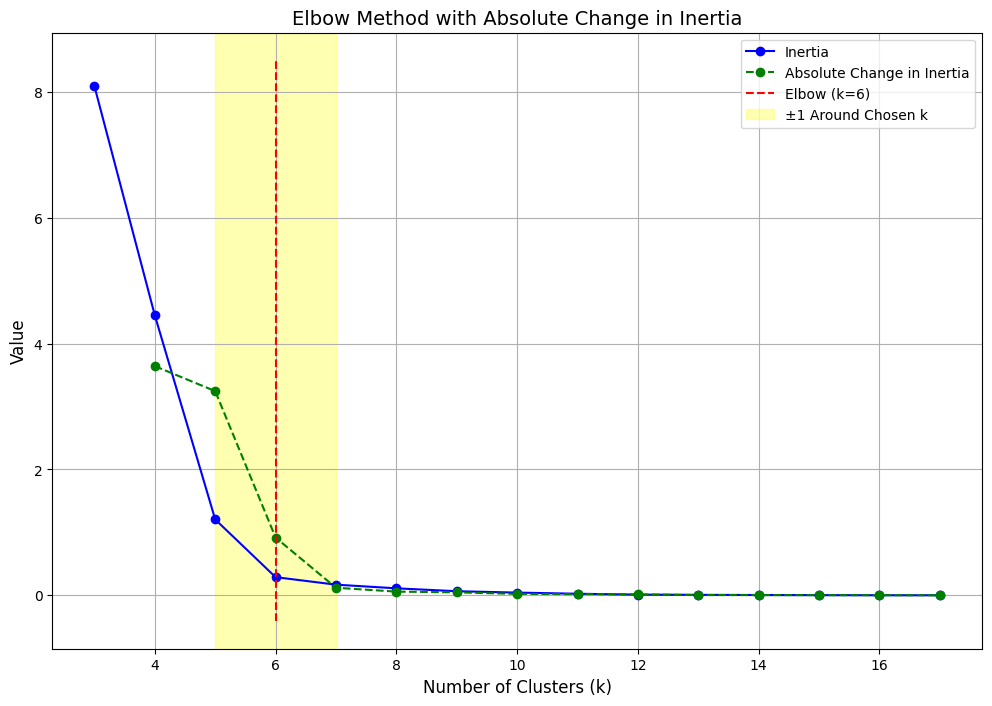

Optimal number of clusters for year 2000: 6
Processing year: 2001
Max clusters for year 2001: 17


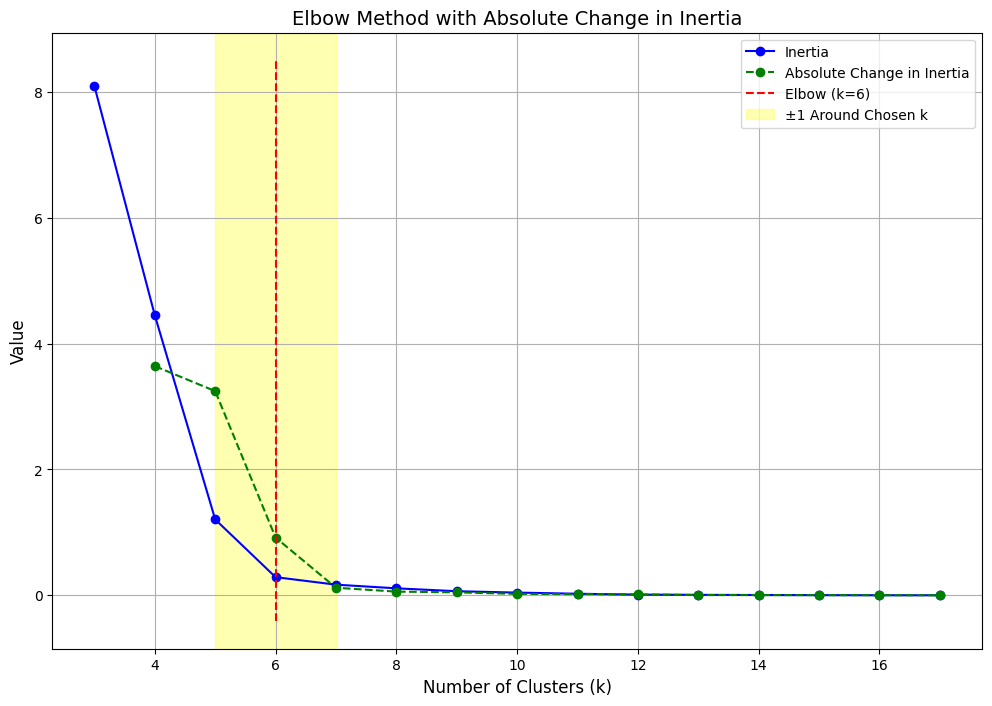

Optimal number of clusters for year 2001: 6
Processing year: 2002
Max clusters for year 2002: 17


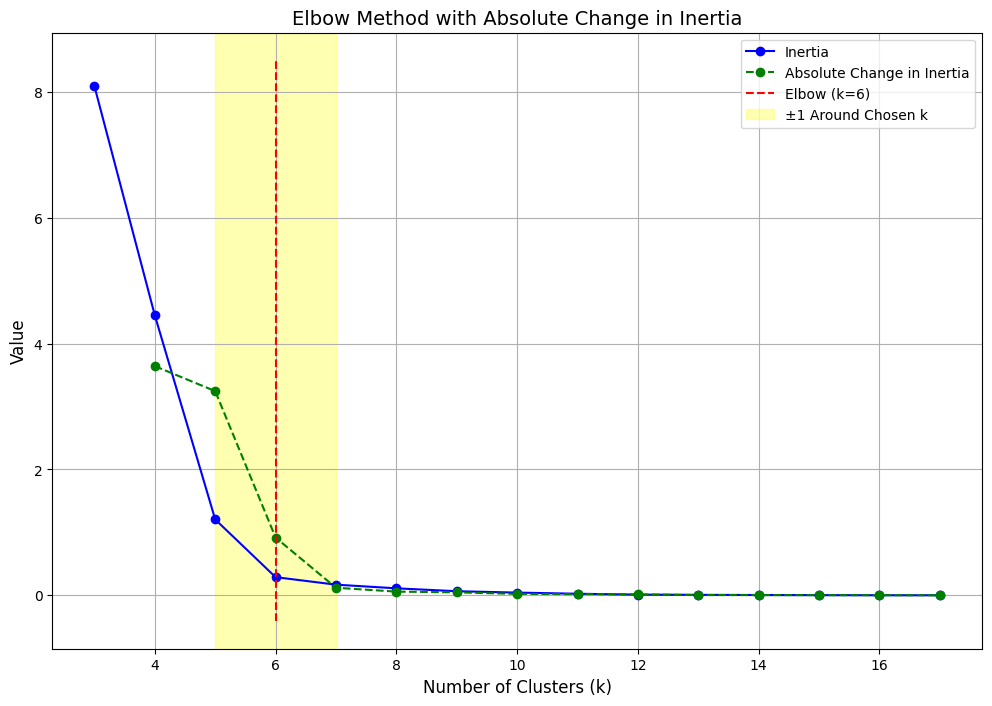

Optimal number of clusters for year 2002: 6
Processing year: 2003
Max clusters for year 2003: 16


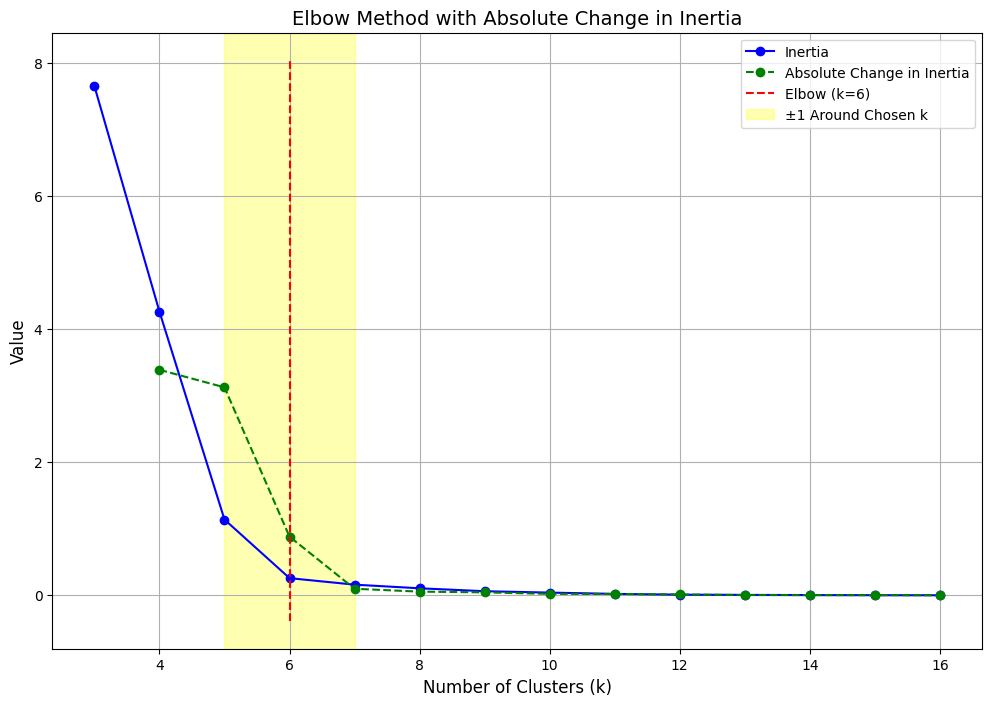

Optimal number of clusters for year 2003: 6
Processing year: 2004
Max clusters for year 2004: 18


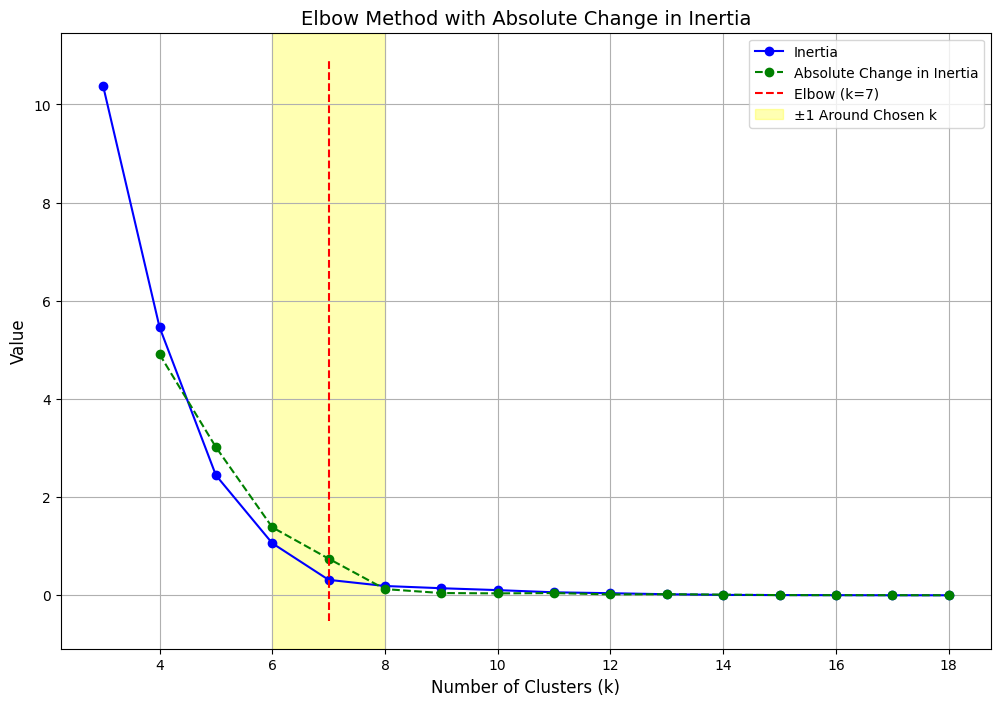

Optimal number of clusters for year 2004: 7
Processing year: 2005
Max clusters for year 2005: 19


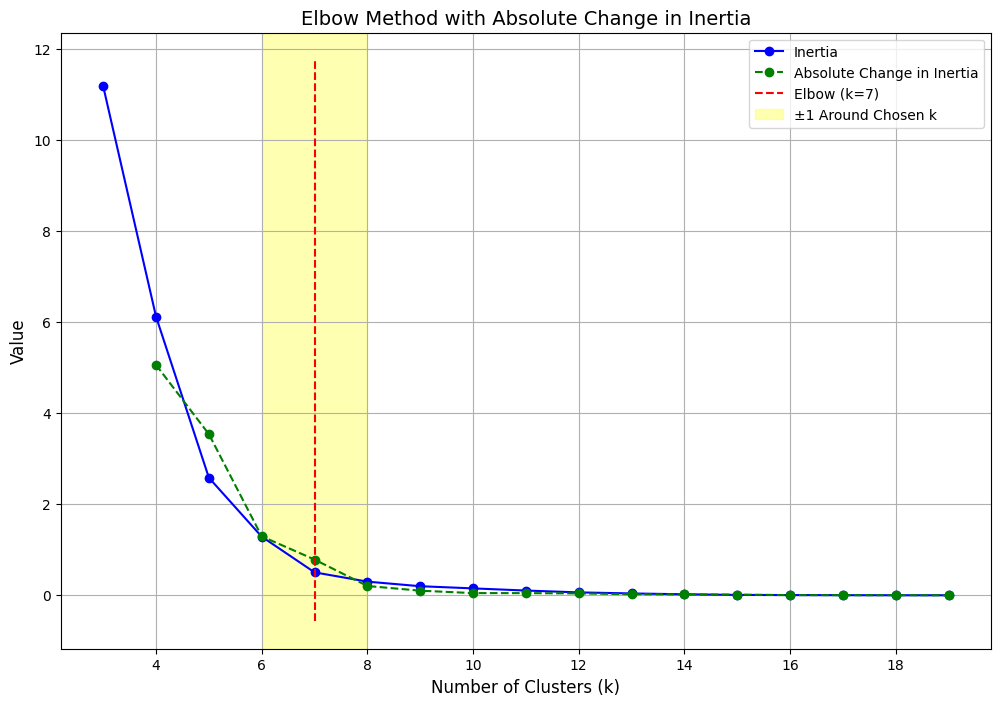

Optimal number of clusters for year 2005: 7
Processing year: 2006
Max clusters for year 2006: 18


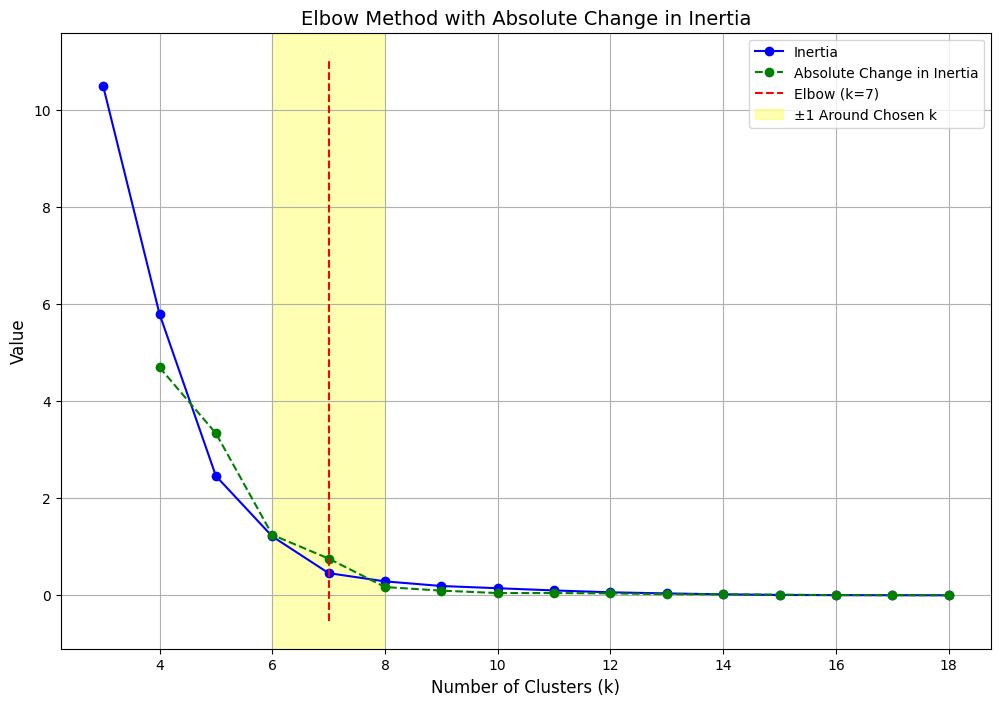

Optimal number of clusters for year 2006: 7
Processing year: 2007
Max clusters for year 2007: 17


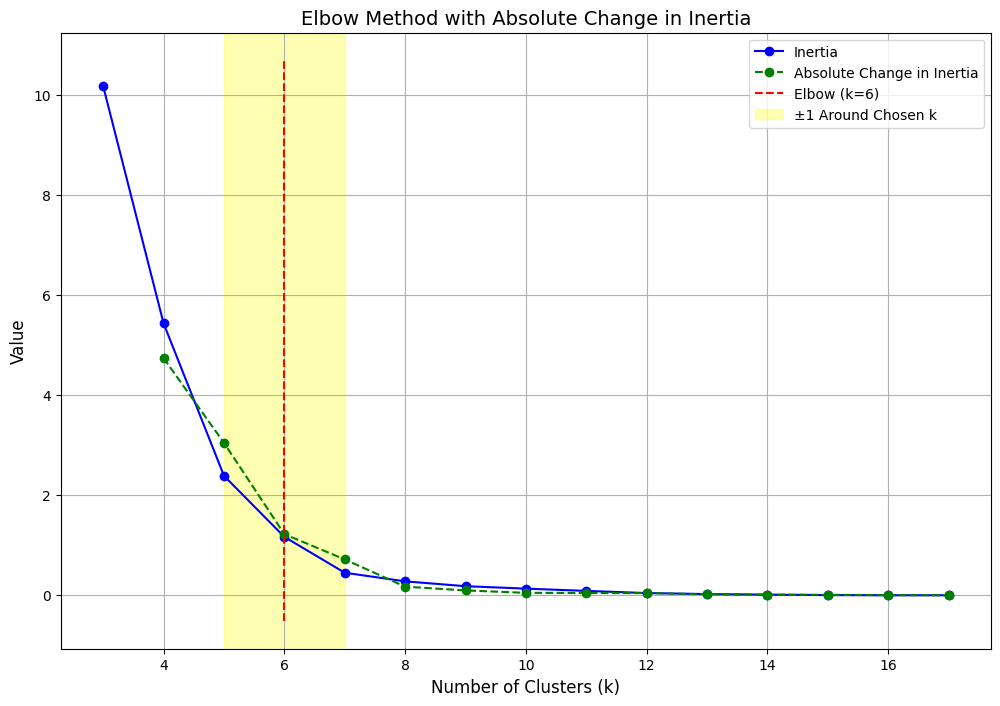

Optimal number of clusters for year 2007: 6
Processing year: 2008
Max clusters for year 2008: 18


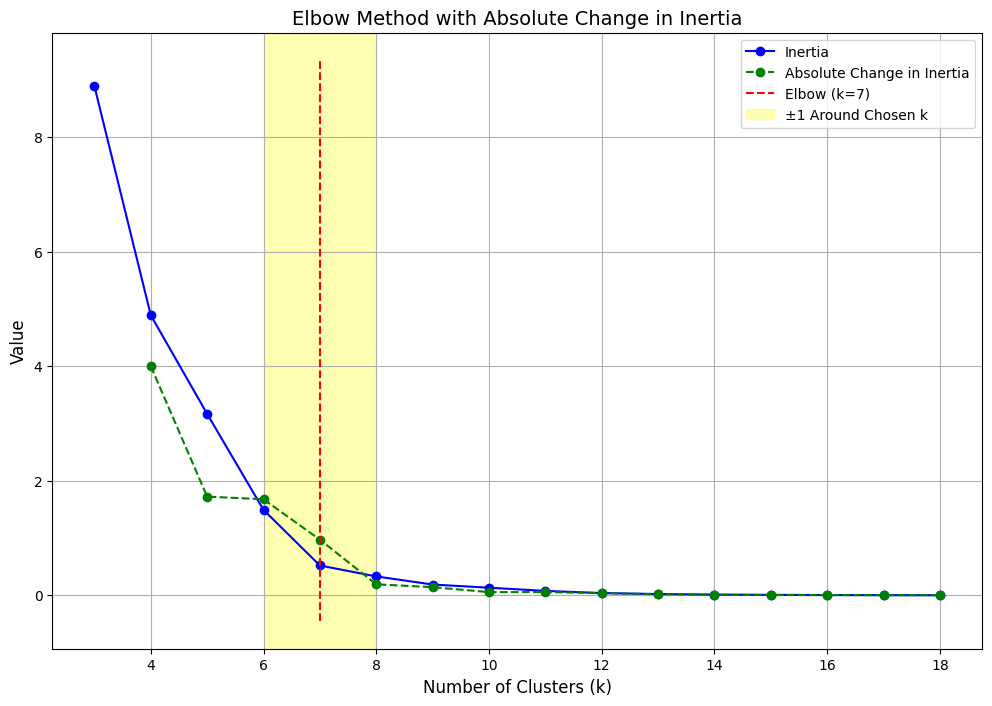

Optimal number of clusters for year 2008: 7
Processing year: 2009
Max clusters for year 2009: 17


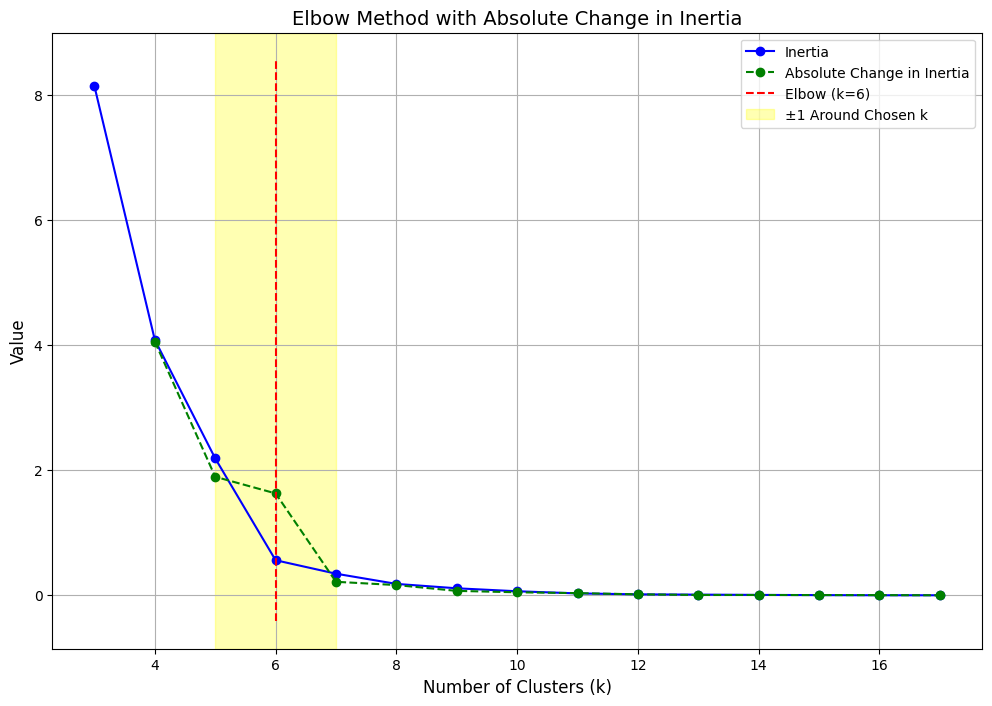

Optimal number of clusters for year 2009: 6
Processing year: 2010
Max clusters for year 2010: 19


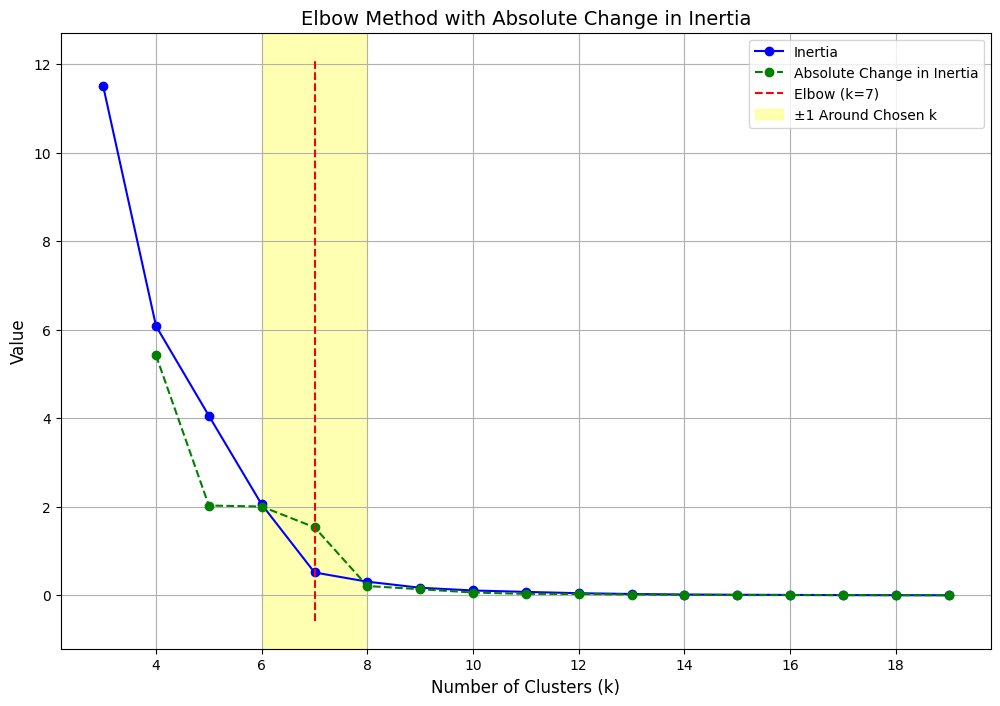

Optimal number of clusters for year 2010: 7
Processing year: 2011
Max clusters for year 2011: 19


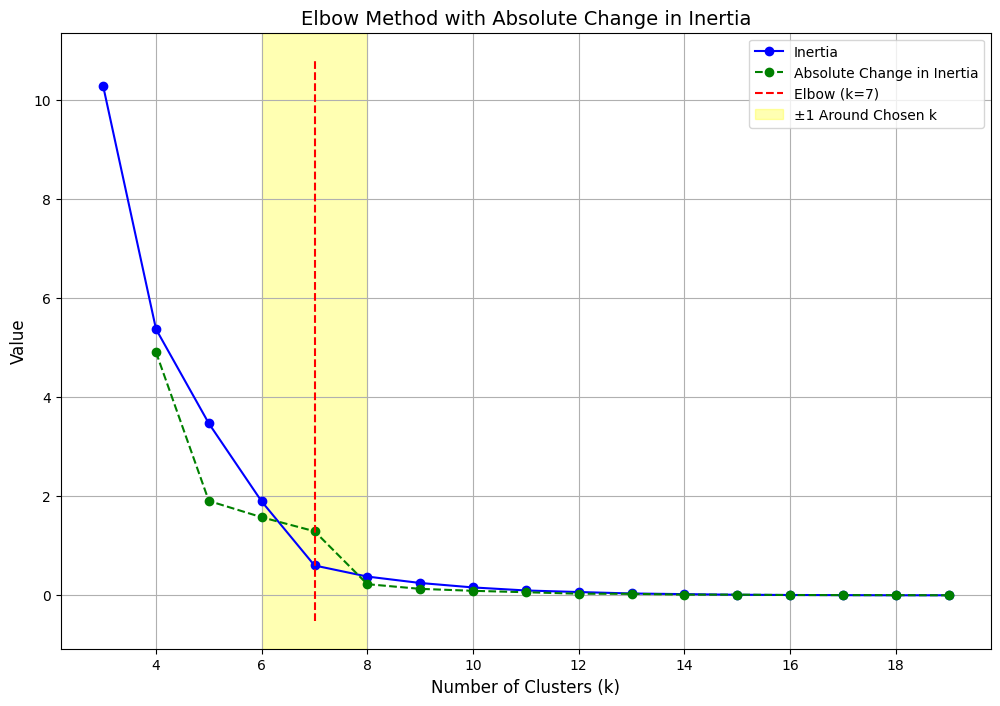

Optimal number of clusters for year 2011: 7
Processing year: 2012
Max clusters for year 2012: 20


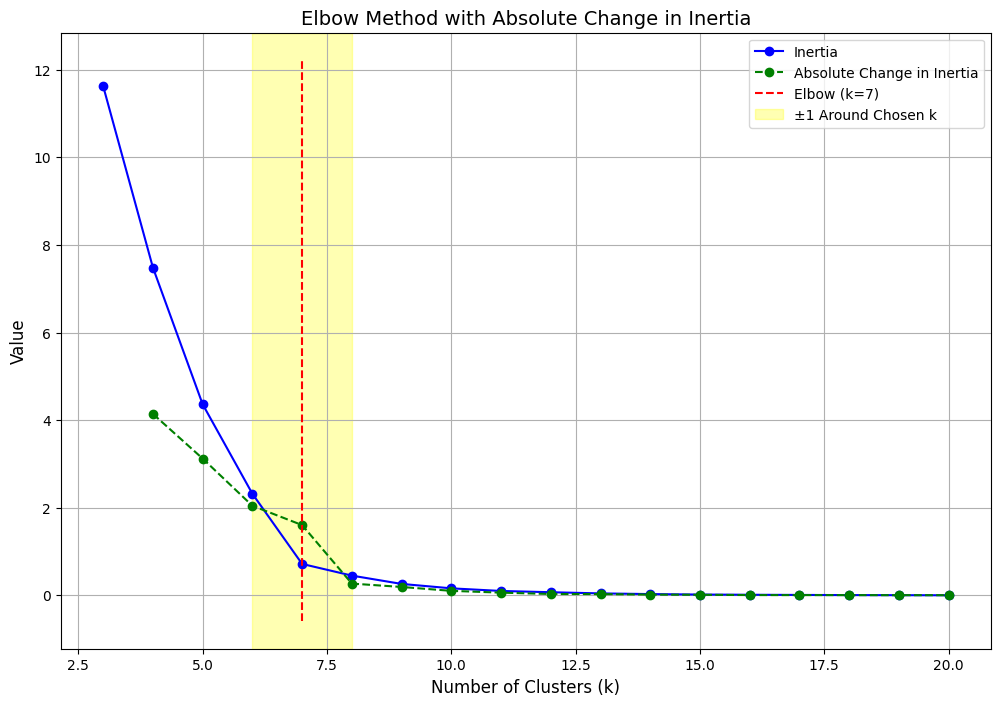

Optimal number of clusters for year 2012: 7
Processing year: 2013
Max clusters for year 2013: 19


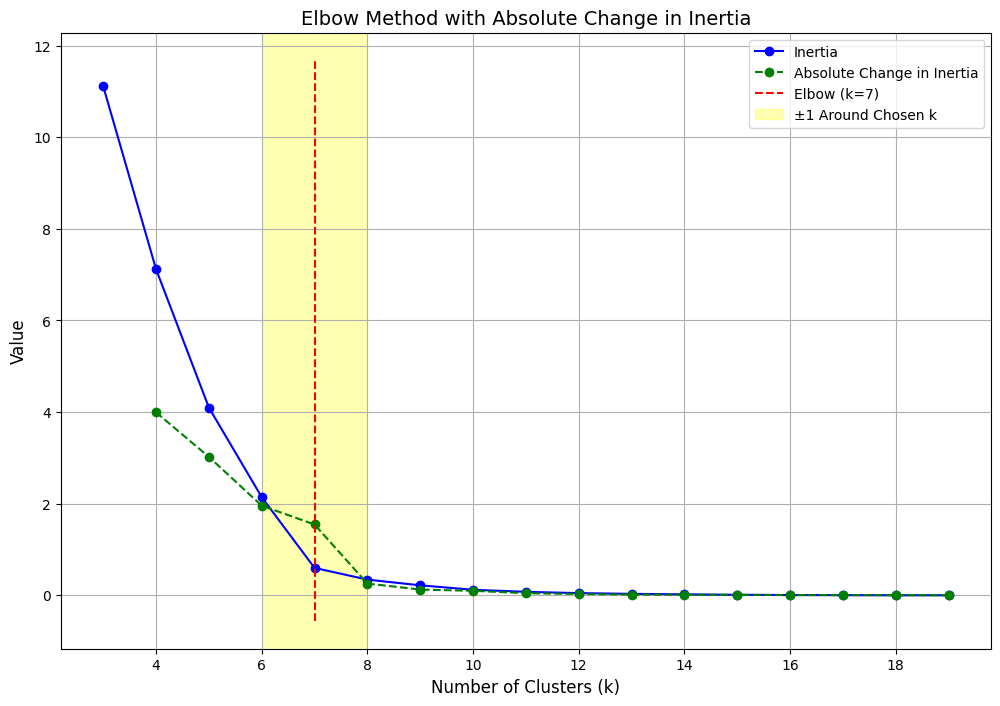

Optimal number of clusters for year 2013: 7
Processing year: 2014
Max clusters for year 2014: 19


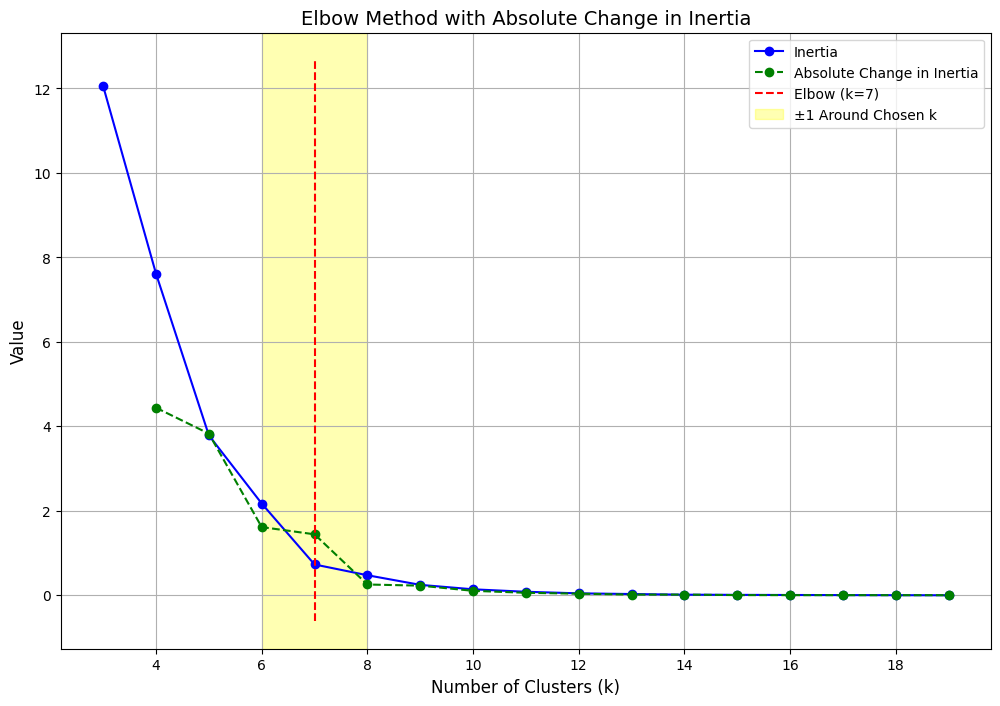

Optimal number of clusters for year 2014: 7
Processing year: 2015
Max clusters for year 2015: 19


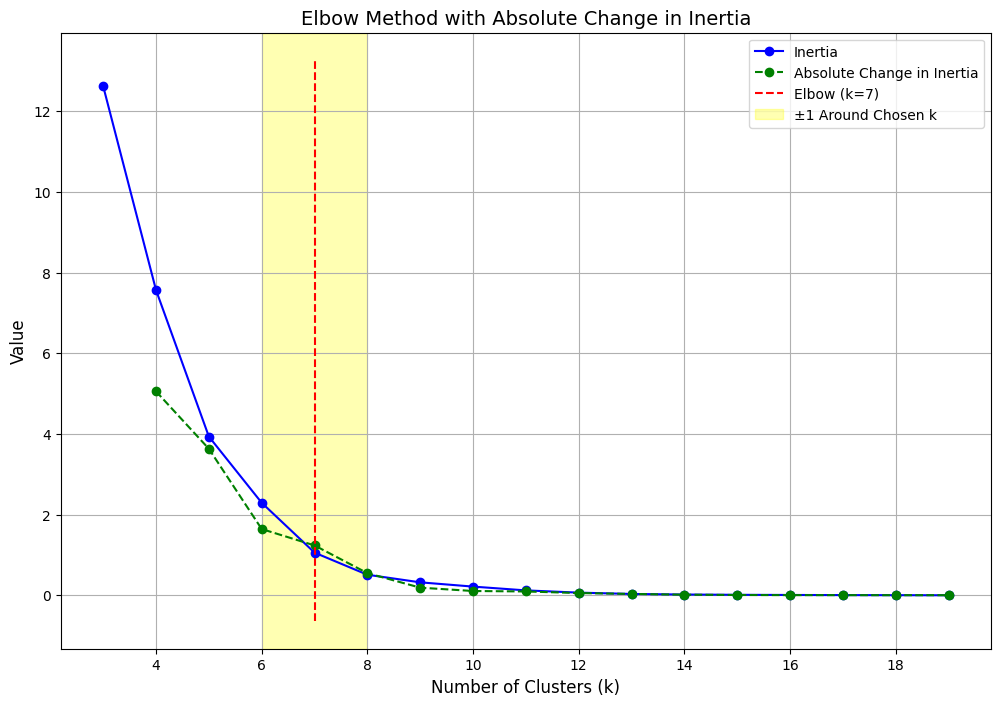

Optimal number of clusters for year 2015: 7
Processing year: 2016
Max clusters for year 2016: 21


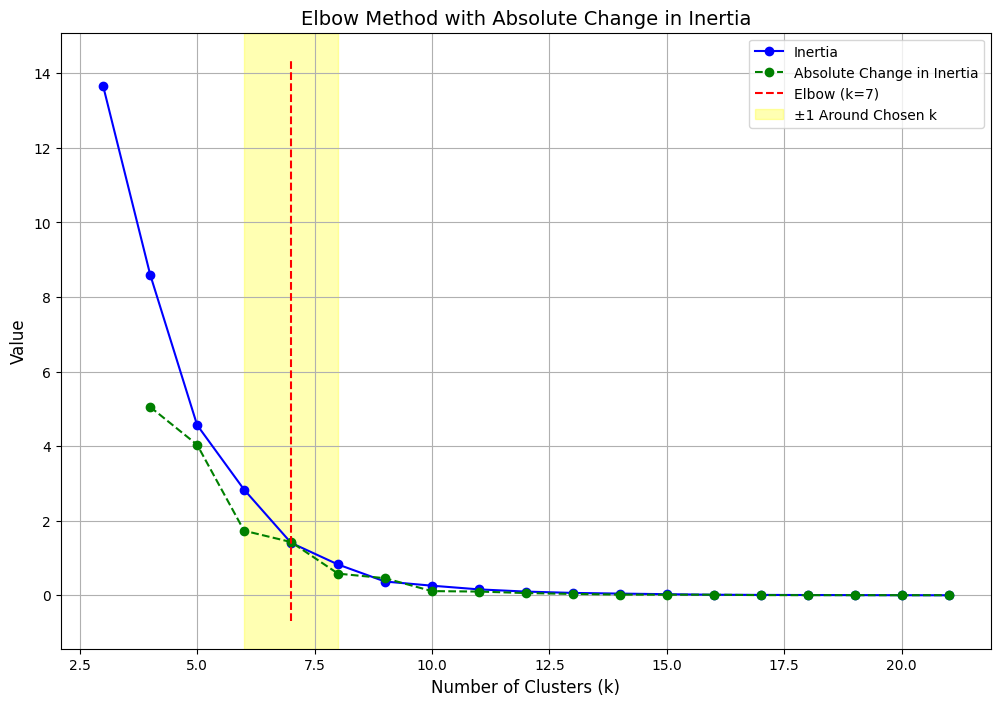

Optimal number of clusters for year 2016: 7
Processing year: 2017
Max clusters for year 2017: 20


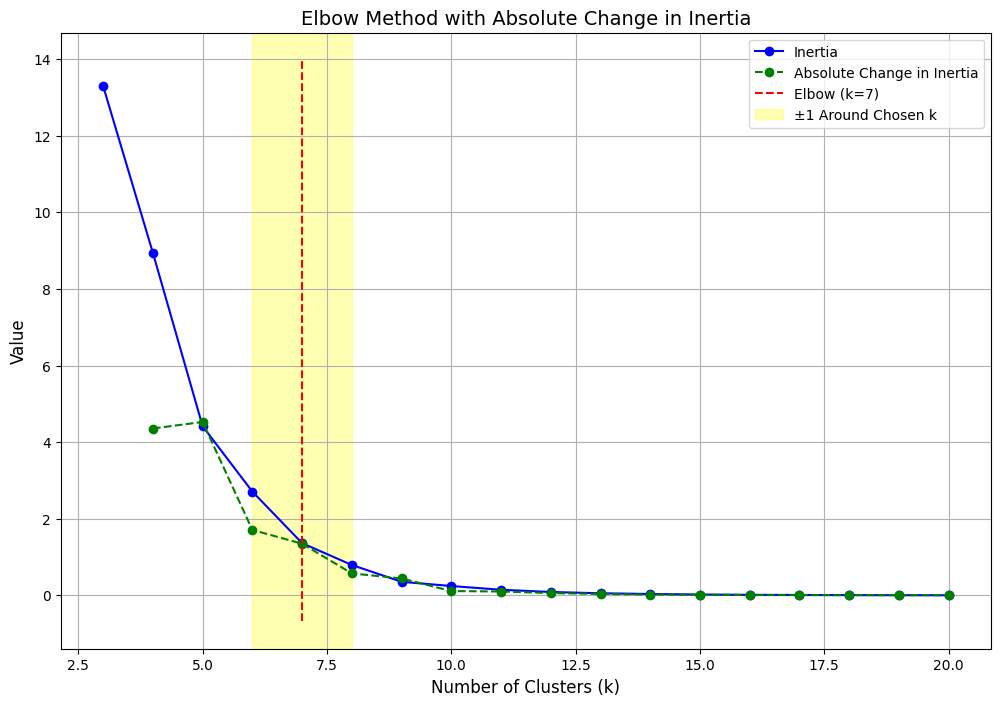

Optimal number of clusters for year 2017: 7
Processing year: 2018
Max clusters for year 2018: 21


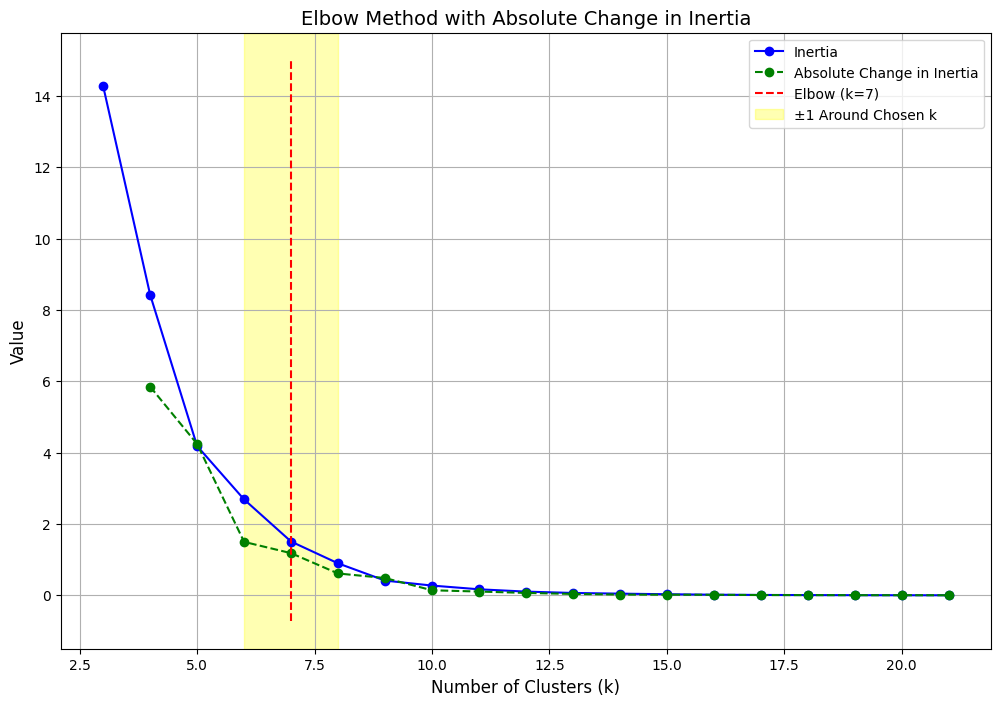

Optimal number of clusters for year 2018: 7
Processing year: 2019
Max clusters for year 2019: 21


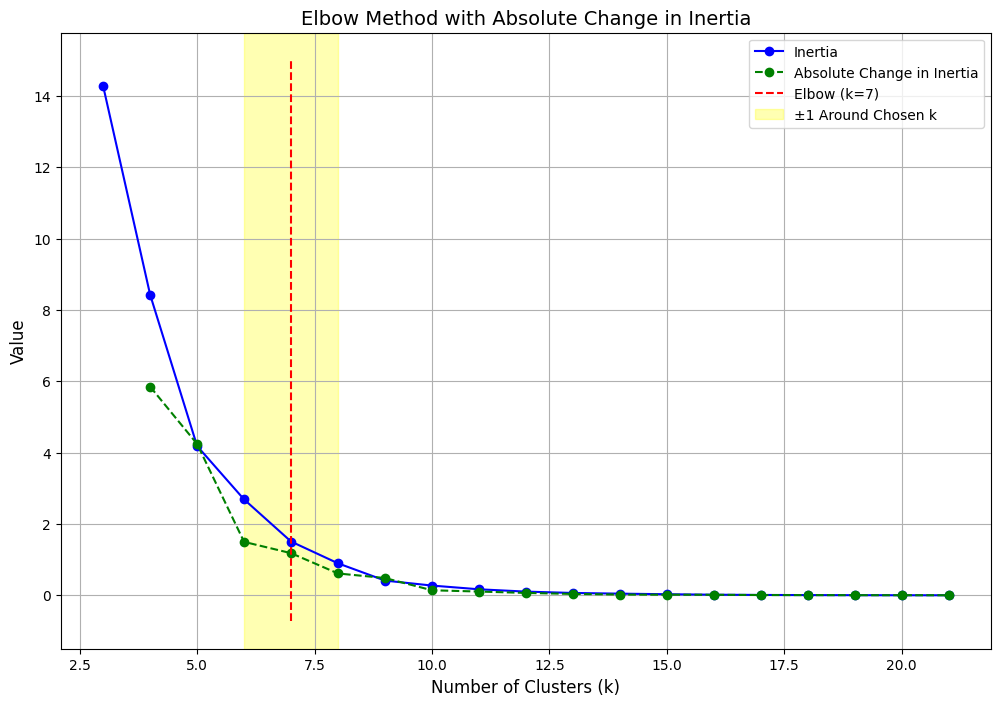

Optimal number of clusters for year 2019: 7
Processing year: 2020
Max clusters for year 2020: 14


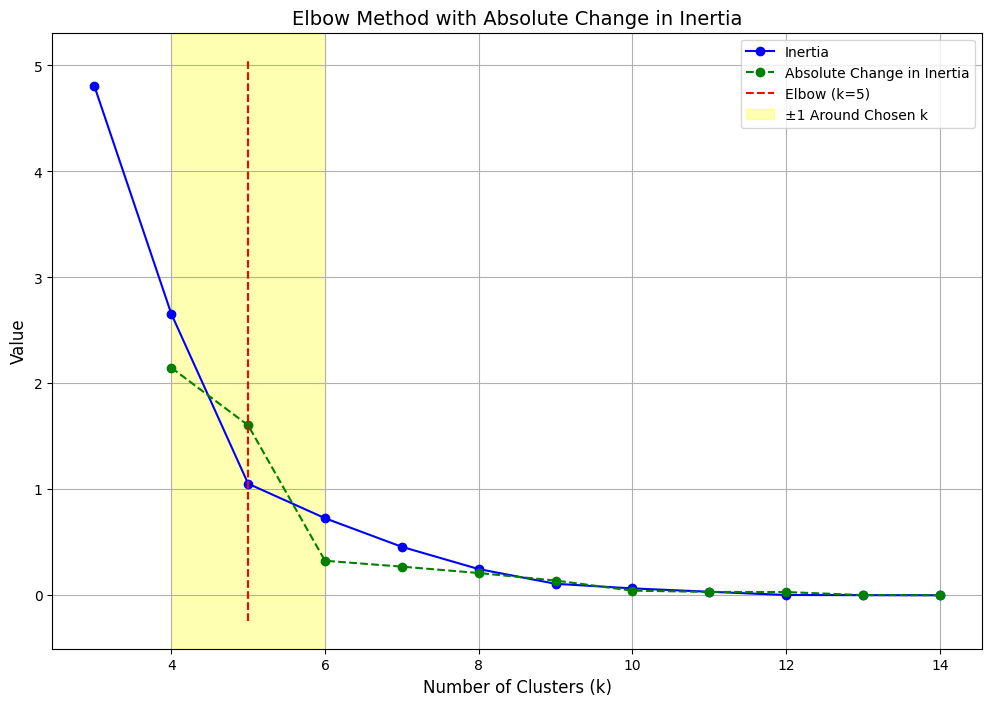

Optimal number of clusters for year 2020: 5
Processing year: 2021
Max clusters for year 2021: 21


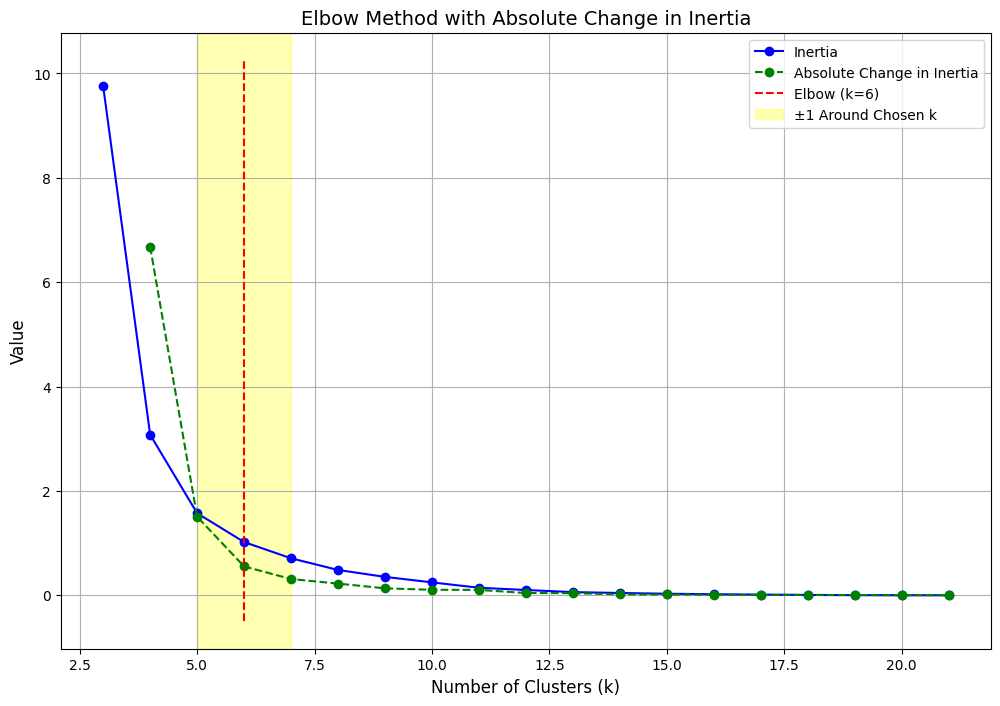

Optimal number of clusters for year 2021: 6
Processing year: 2022
Max clusters for year 2022: 22


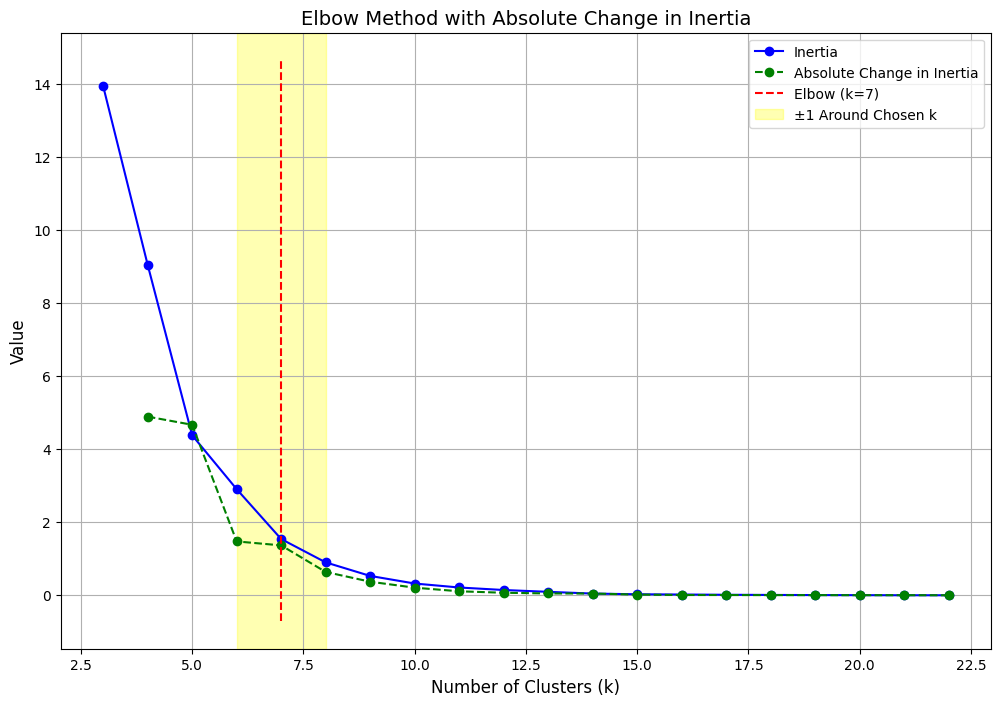

Optimal number of clusters for year 2022: 7
Processing year: 2023
Max clusters for year 2023: 22


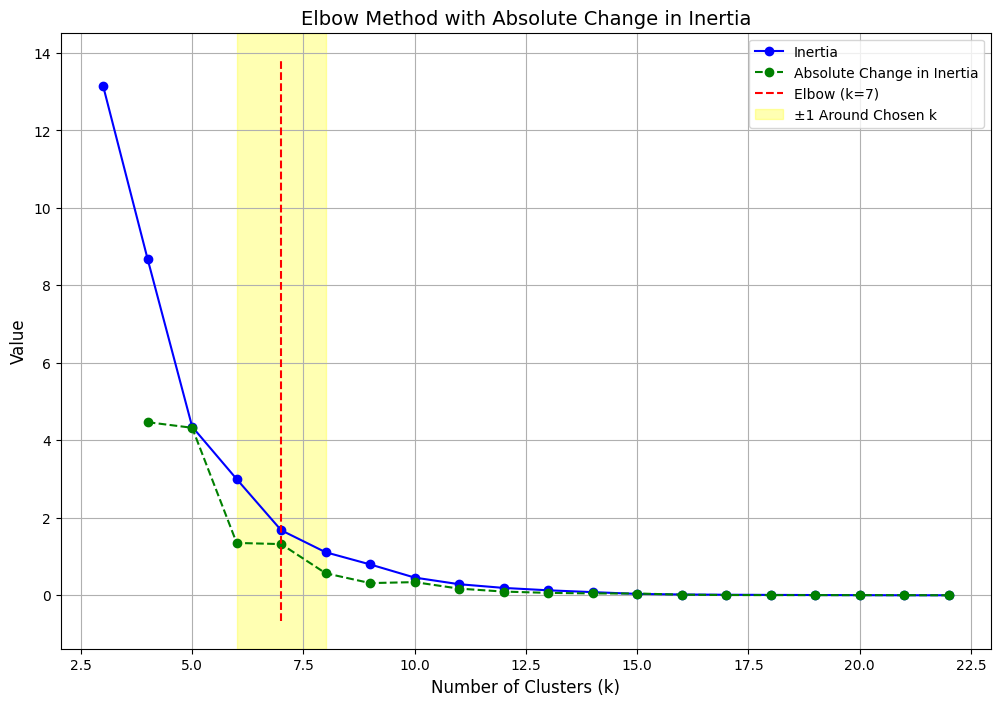

Optimal number of clusters for year 2023: 7
Processing year: 2024
Max clusters for year 2024: 24


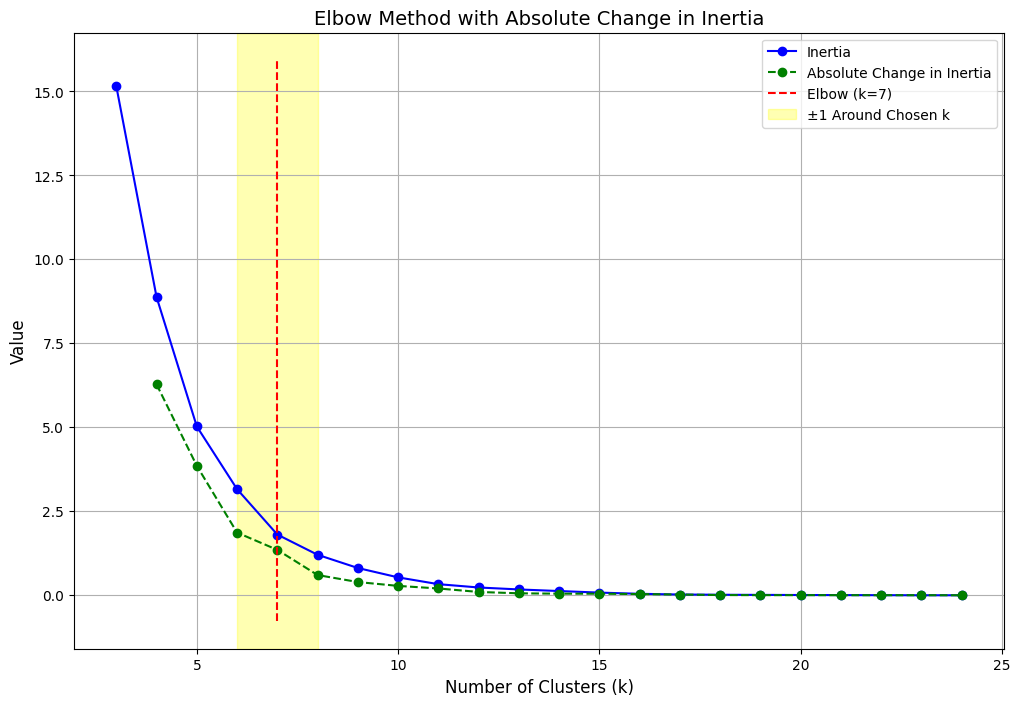

Optimal number of clusters for year 2024: 7
Processing year: 2025
Max clusters for year 2025: 24


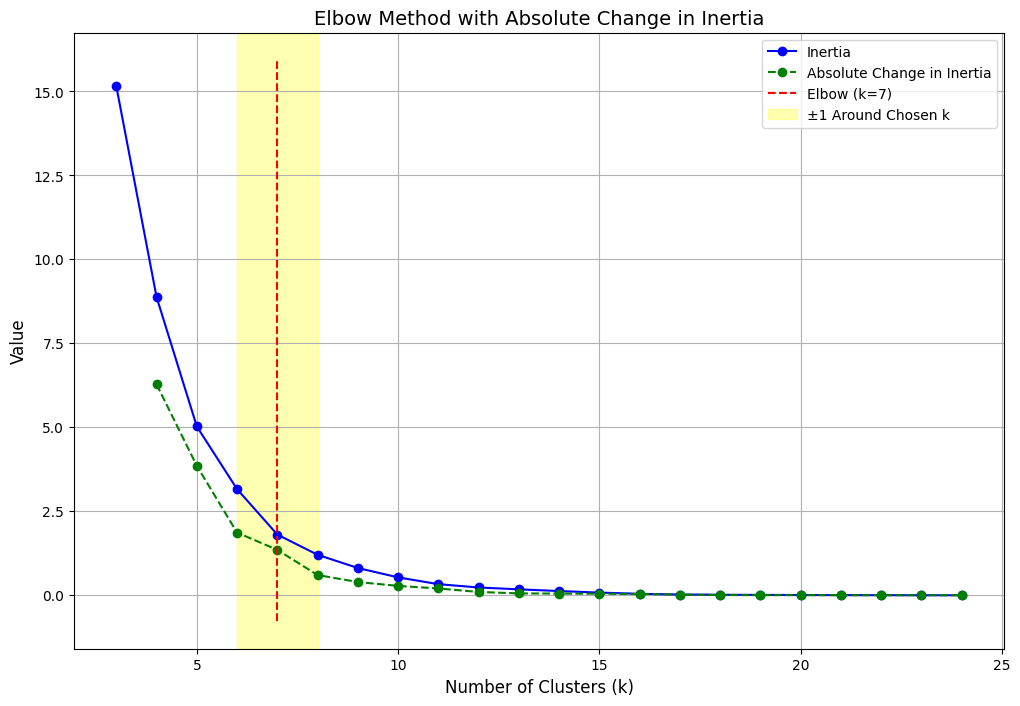

Optimal number of clusters for year 2025: 7


In [13]:
for year in range(2000, 2026):
    print(f"Processing year: {year}")
    df_circuits_for_clustering = get_historical_cities(year)
    coords = scale_coords(df_circuits_for_clustering)
    max_clusters = len(df_circuits_for_clustering)
    print(f"Max clusters for year {year}: {max_clusters}")
    optimal_k = kmeans_plot_elbow(coords, max_clusters=max_clusters, random_state=23, img_verbose=True)
    print(f"Optimal number of clusters for year {year}: {optimal_k}")

In [26]:
def clusterize_circuits(year=None, df=None, verbose=False, opt_k_img_verbose=False, fig_verbose=False):
    """
    Clusterize circuits based on their geographical coordinates.

    Args:
        year (int, optional): The year to fetch historical cities data. Required if df is not provided.
        df (pd.DataFrame, optional): DataFrame containing 'city', 'latitude', and 'longitude'. Required if year is not provided.
        verbose (bool, optional): Whether to print debug information. Default is False.
        img_verbose (bool, optional): Whether to display the elbow plot. Default is False.
        fig_verbose (bool, optional): Whether to display the final cluster visualization. Default is False.

    Returns:
        pd.DataFrame: DataFrame with an additional 'cluster_id' column.
    """
    if verbose:
        print("Starting clusterization process...")

    if df is None and year is None:
        raise ValueError("Either 'year' or 'df' must be provided.")
    
    # Fetch data if year is provided
    if year is not None:
        if verbose:
            print(f"Fetching historical cities data for year {year}...")
        df = get_historical_cities(year, verbose=verbose)
    
    # Ensure the DataFrame has the required columns
    required_columns = {'city', 'latitude', 'longitude'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")
    
    # Scale the coordinates
    if verbose:
        print("Scaling coordinates...")
    coords = scale_coords(df, verbose=verbose)
    
    # Determine the optimal number of clusters using the elbow method
    max_clusters = len(df)
    if verbose:
        print(f"Determining optimal number of clusters (max_clusters={max_clusters})...")
    optimal_k = kmeans_plot_elbow(coords, max_clusters=max_clusters, random_state=23, verbose=verbose, img_verbose=opt_k_img_verbose)
    
    # Perform K-Means clustering
    if verbose:
        print(f"Running K-Means with k={optimal_k}...")
    kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=23)
    kmeans.fit(coords)
    cluster_labels = kmeans.labels_
    
    # Add cluster IDs to the DataFrame
    if verbose:
        print("Assigning cluster IDs to circuits...")
    clustered_df = df.copy()
    clustered_df['cluster_id'] = cluster_labels
    clustered_df['cluster_id'] = clustered_df['cluster_id'].astype(str)
    if verbose:
        print("Cluster IDs assigned successfully.")
    
    # Generate visualization if fig_verbose is True
    if fig_verbose:
        if verbose:
            print("\n--- Generating Enhanced Plotly Map ---")
        # Group cities by cluster_id for legend
        cluster_cities = clustered_df.groupby('cluster_id')['city'].apply(lambda x: ', '.join(x)).to_dict()
        fig = px.scatter_geo(
            data_frame=clustered_df,
            lat='latitude',
            lon='longitude',
            color='cluster_id',
            hover_name='city',
            projection='natural earth',
            title=f'F1 Circuit Clusters (k={optimal_k})',
            color_discrete_sequence=px.colors.qualitative.Set1,
            size_max=20
        )
        fig.update_traces(
            marker=dict(size=10)
        )
        fig.update_geos(
            visible=True, resolution=50,
            showcountries=True, countrycolor="Black",
            showsubunits=True, subunitcolor="Blue"
        )
        # Update legend to include cities in each cluster with text wrapping
        fig.update_layout(
            margin={"r": 0, "t": 40, "l": 0, "b": 0},
            title_font_size=14,  # Scale down the title size
            legend_title_text='Cluster (Cities)',
            legend=dict(
            itemsizing='constant',
            title_font_size=12,
            font_size=10,
            traceorder='normal'
            )
        )
        for trace in fig.data:
            cluster_id = trace.name
            if cluster_id in cluster_cities:
                # Wrap text to include 3 cities per line in the legend
                cities = cluster_cities[cluster_id].split(', ')
                wrapped_cities = '<br>'.join([', '.join(cities[i:i+3]) for i in range(0, len(cities), 3)])
                trace.name = f"Cluster {cluster_id}:<br>{wrapped_cities}"
        fig.show()
        if verbose:
            print("\nEnhanced Plotly figure object 'fig' created.")
    if verbose:
        print("Clusterization process completed.")
    
    return clustered_df


In [27]:
clusterized_df = clusterize_circuits(year=2025, fig_verbose=True)

testing clustering on random samples

In [11]:
def get_random_sample(n, verbose=False):
    """
    Fetches a random n-sized sample of city_x, latitude, and longitude from the fone_geography table.

    Args:
        n (int): The number of random rows to fetch.
        verbose (bool): If True, prints debug information.

    Returns:
        pandas.DataFrame: A DataFrame containing the random sample.
    """
    if verbose:
        print(f"Fetching a random sample of {n} rows from the database...")

    # Connect to the database
    connection = sqlite3.connect('planet_fone.db')

    # SQL query to fetch random n rows
    query = f"""
    SELECT city_x AS city, latitude, longitude
    FROM fone_geography
    ORDER BY RANDOM()
    LIMIT {n};
    """

    # Execute the query and load the results into a DataFrame
    sample_df = pd.read_sql_query(query, connection)

    # Close the connection
    connection.close()

    if verbose:
        print(f"Random sample of {n} rows fetched successfully.")
    return sample_df

Processing random sample of size 15 (iteration 1)...
Fetching a random sample of 15 rows from the database...
Random sample of 15 rows fetched successfully.
List of cities in the random sample:
['Montreal', 'Valencia', 'Zandvoort', 'Miami', 'Oslo', 'Vancouver', 'Spielberg', 'Sakhir', 'Shanghai', 'Imola', 'Mogyoród', 'Greater Noida', 'Monza', 'Austin', 'Sochi']


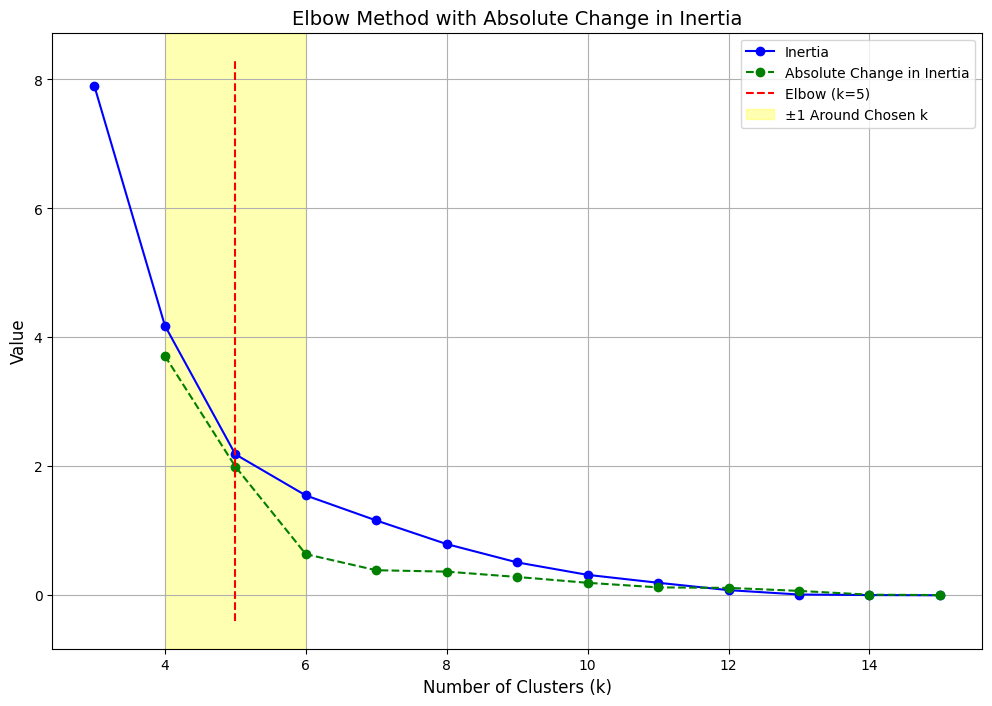

Processing random sample of size 16 (iteration 1)...
Fetching a random sample of 16 rows from the database...
Random sample of 16 rows fetched successfully.
List of cities in the random sample:
['Zandvoort', 'Monte Carlo', 'Vancouver', 'Jeddah', 'Singapore', 'Seoul', 'Shanghai', 'Greater Noida', 'Scarperia e San Piero', 'Yeongam', 'Mogyoród', 'Silverstone', 'Indianapolis', 'Sepang', 'Sakhir', 'Oslo']


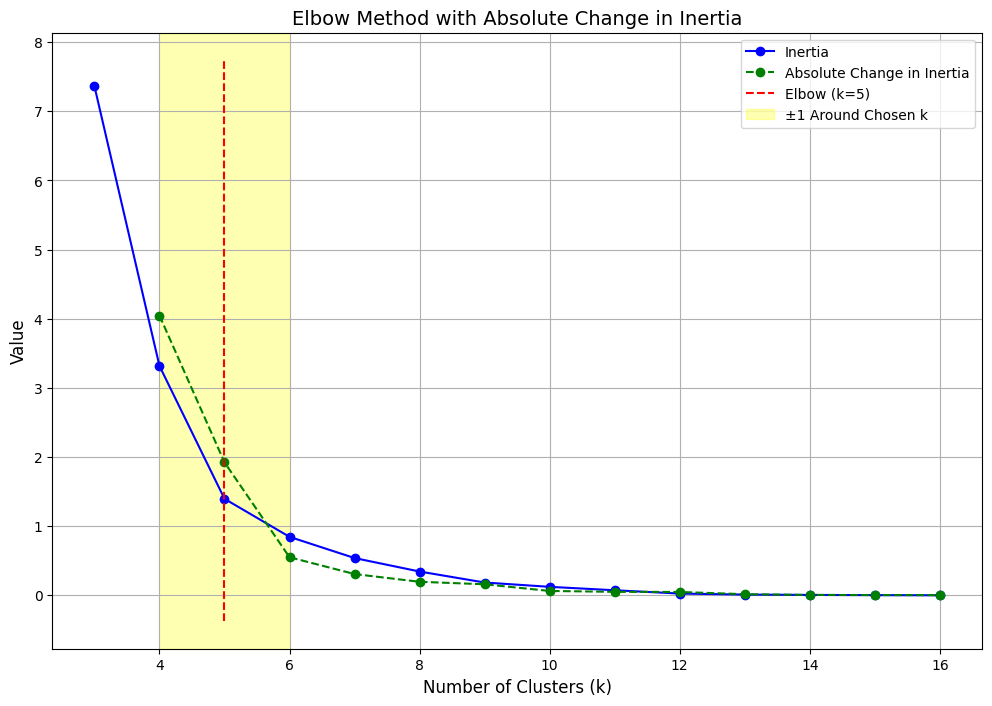

Processing random sample of size 17 (iteration 1)...
Fetching a random sample of 17 rows from the database...
Random sample of 17 rows fetched successfully.
List of cities in the random sample:
['Greater Noida', 'Monza', 'Sepang', 'Kuala Terengganu', 'Montreal', 'Lagos', 'Mogyoród', 'Baku', 'Imola', 'Yeongam', 'Lusail', 'Jeddah', 'Vancouver', 'Monte Carlo', 'Chicago', 'Buenos Aires', 'Istanbul']


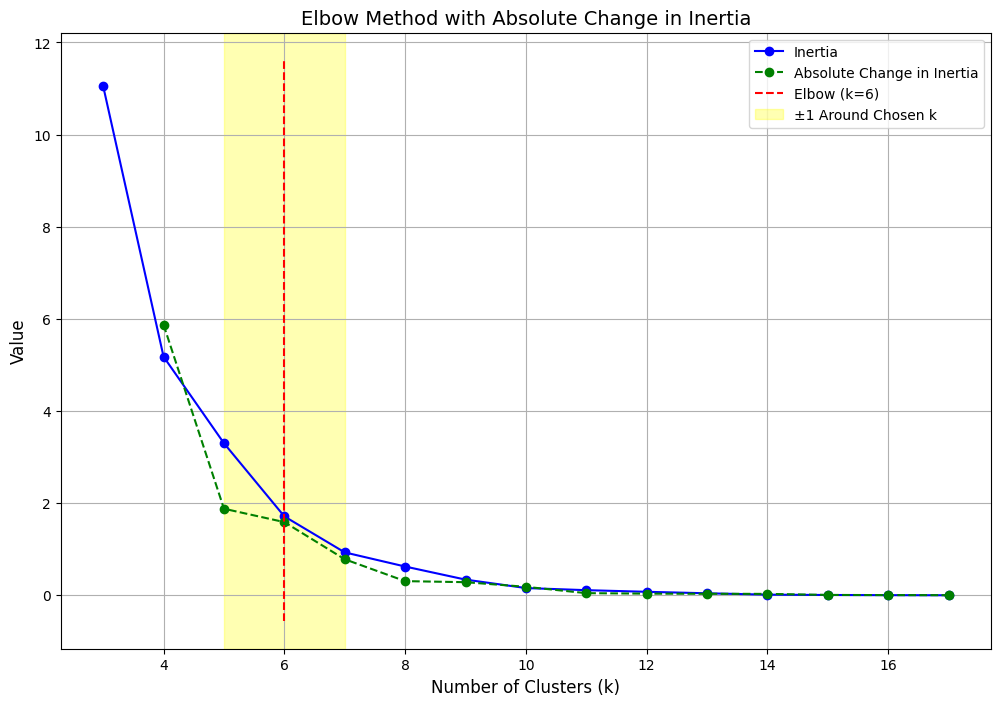

Processing random sample of size 18 (iteration 1)...
Fetching a random sample of 18 rows from the database...
Random sample of 18 rows fetched successfully.
List of cities in the random sample:
['Lusail', 'Shanghai', 'Melbourne', 'Riyadh', 'Montmeló', 'Portimão', 'Monte Carlo', 'Lagos', 'Mexico City', 'Seoul', 'Oslo', 'Le Castellet', 'Buenos Aires', 'Yeongam', 'Istanbul', 'Oyama', 'Vancouver', 'Abu Dhabi']


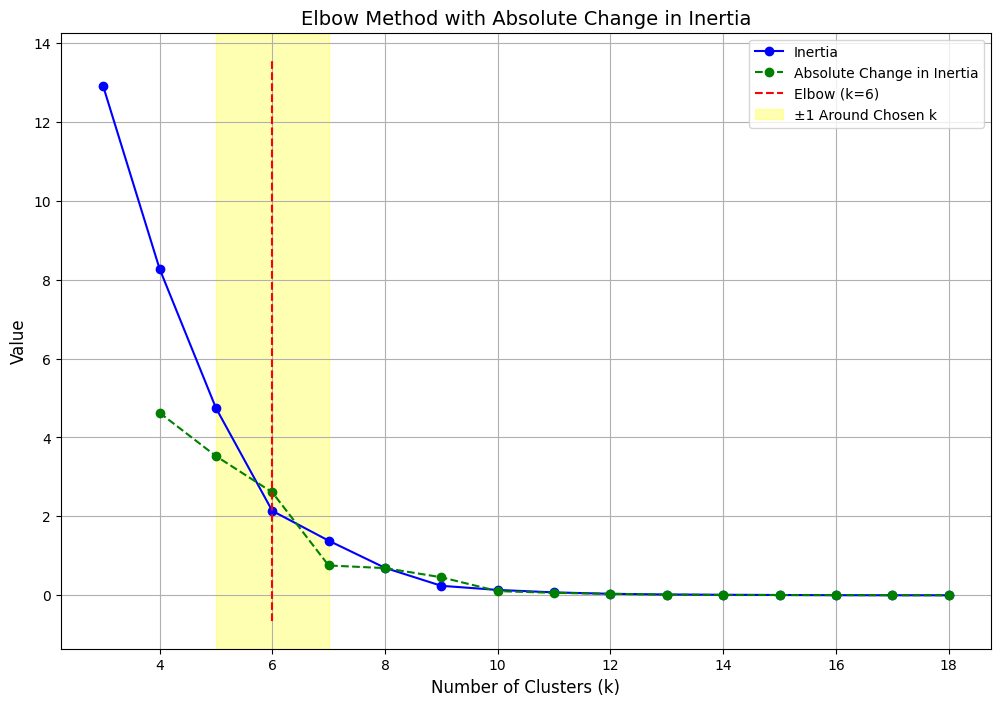

Processing random sample of size 19 (iteration 1)...
Fetching a random sample of 19 rows from the database...
Random sample of 19 rows fetched successfully.
List of cities in the random sample:
['Stavelot', 'Monte Carlo', 'Monza', 'Oyama', 'Sakhir', 'Greater Noida', 'Scarperia e San Piero', 'Abu Dhabi', 'Seoul', 'Oslo', 'Suzuka', 'Auckland', 'Baku', 'Cape Town', 'Indianapolis', 'Montreal', 'Mexico City', 'Nürburg', 'Jeddah']


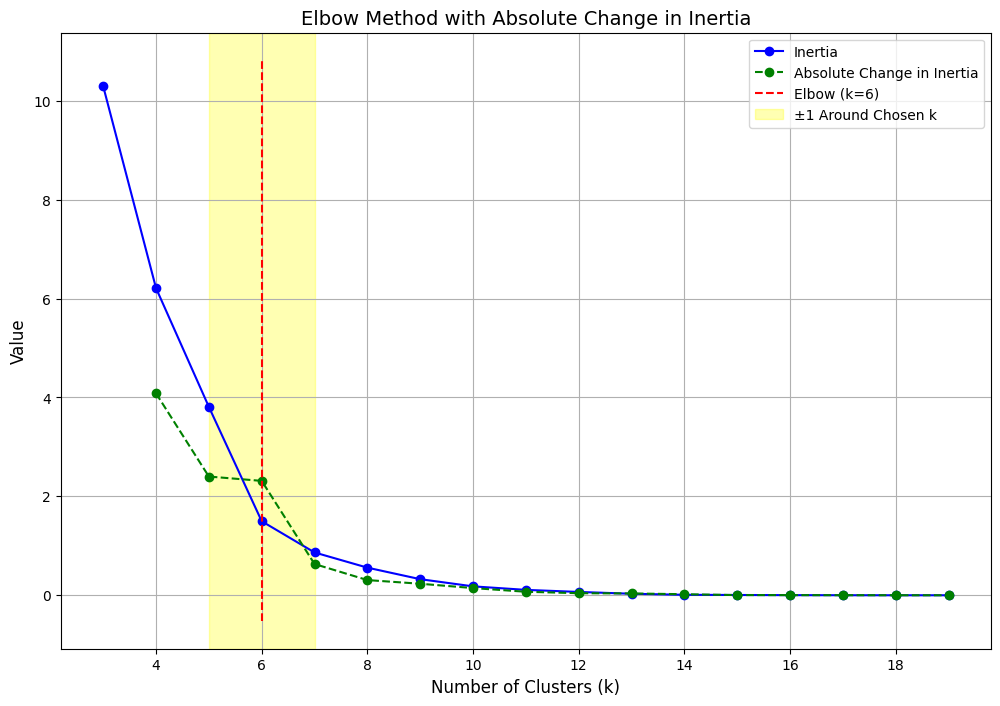

Processing random sample of size 20 (iteration 1)...
Fetching a random sample of 20 rows from the database...
Random sample of 20 rows fetched successfully.
List of cities in the random sample:
['Kuala Terengganu', 'Spielberg', 'Baku', 'Istanbul', 'Sakhir', 'Monza', 'Hockenheim', 'Monte Carlo', 'Chicago', 'Oslo', 'Jeddah', 'Riyadh', 'Portimão', 'Vancouver', 'Montreal', 'Lagos', 'Abu Dhabi', 'Mogyoród', 'Zandvoort', 'Sochi']


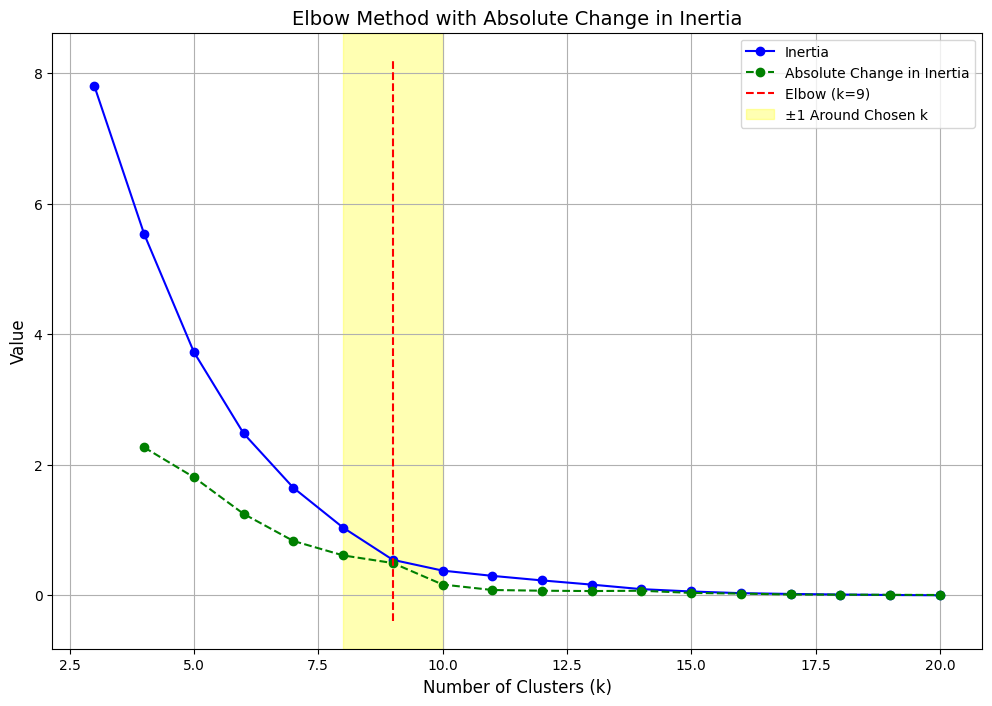

Processing random sample of size 21 (iteration 1)...
Fetching a random sample of 21 rows from the database...
Random sample of 21 rows fetched successfully.
List of cities in the random sample:
['Suzuka', 'Scarperia e San Piero', 'Portimão', 'Imola', 'Baku', 'Austin', 'Valencia', 'Chicago', 'Abu Dhabi', 'Lusail', 'Spielberg', 'Silverstone', 'Monte Carlo', 'Stavelot', 'Magny-Cours', 'Riyadh', 'Sepang', 'Yeongam', 'Mexico City', 'Shanghai', 'Auckland']


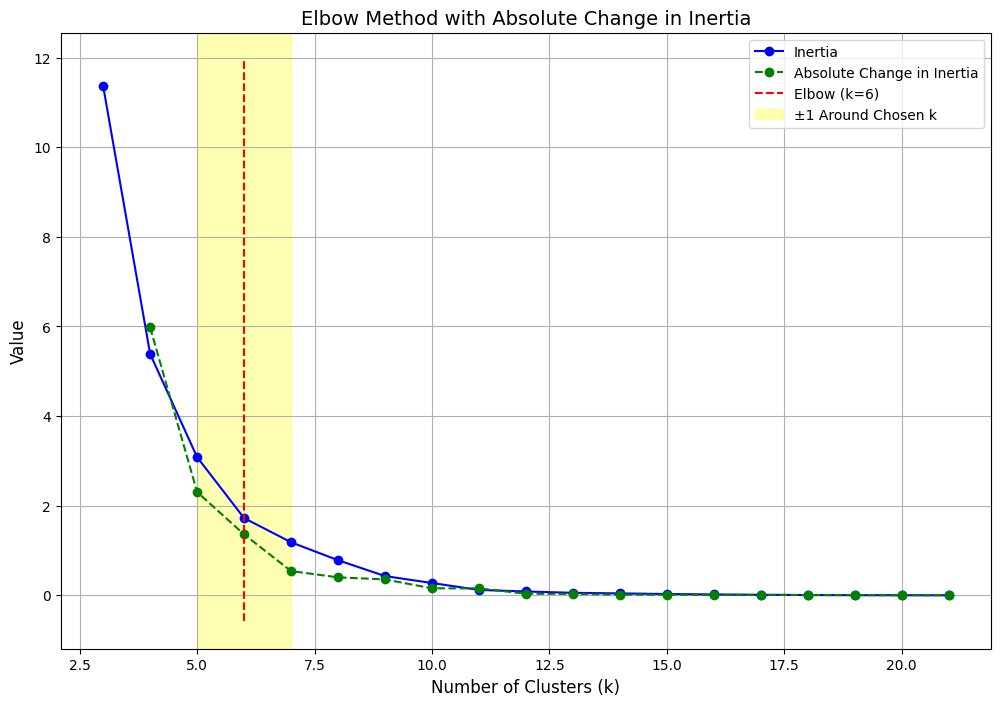

Processing random sample of size 22 (iteration 1)...
Fetching a random sample of 22 rows from the database...
Random sample of 22 rows fetched successfully.
List of cities in the random sample:
['Kuala Terengganu', 'Silverstone', 'Indianapolis', 'Suzuka', 'Monte Carlo', 'Lagos', 'Las Vegas', 'Zandvoort', 'Shanghai', 'Sochi', 'Portimão', 'Oslo', 'Greater Noida', 'Abu Dhabi', 'Chicago', 'Yeongam', 'Scarperia e San Piero', 'Baku', 'Sepang', 'Sakhir', 'Mogyoród', 'Jeddah']


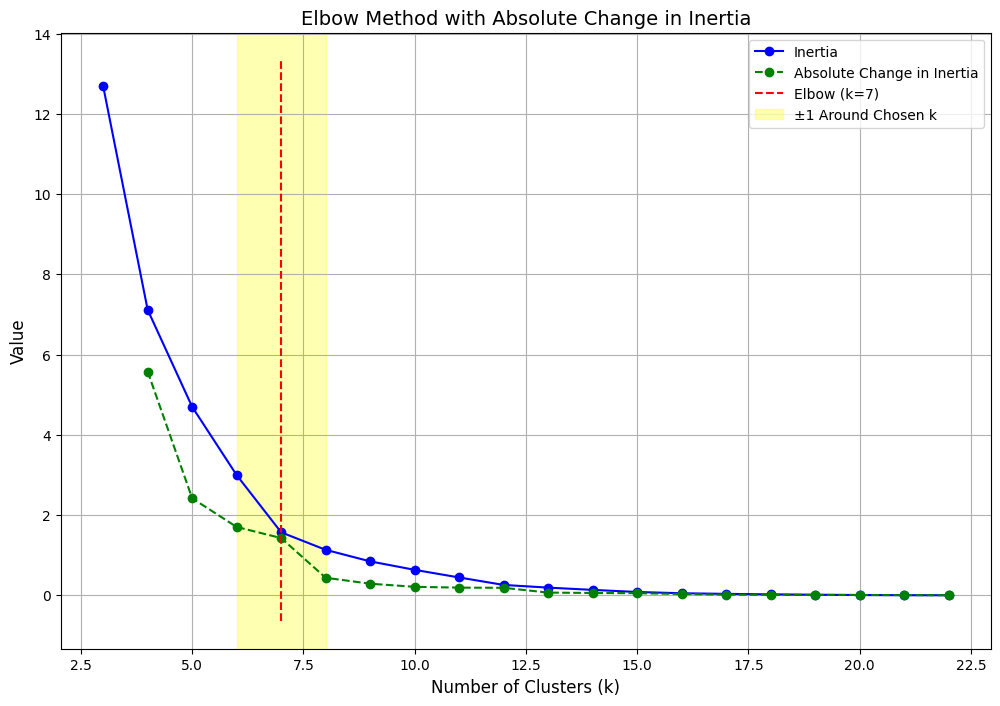

Processing random sample of size 23 (iteration 1)...
Fetching a random sample of 23 rows from the database...
Random sample of 23 rows fetched successfully.
List of cities in the random sample:
['Mexico City', 'Mogyoród', 'Buenos Aires', 'Oslo', 'Jeddah', 'Singapore', 'Montmeló', 'Sakhir', 'Zandvoort', 'Istanbul', 'Monza', 'Sochi', 'Abu Dhabi', 'São Paulo', 'Valencia', 'Montreal', 'Scarperia e San Piero', 'Austin', 'Hockenheim', 'Silverstone', 'Le Castellet', 'Suzuka', 'Lagos']


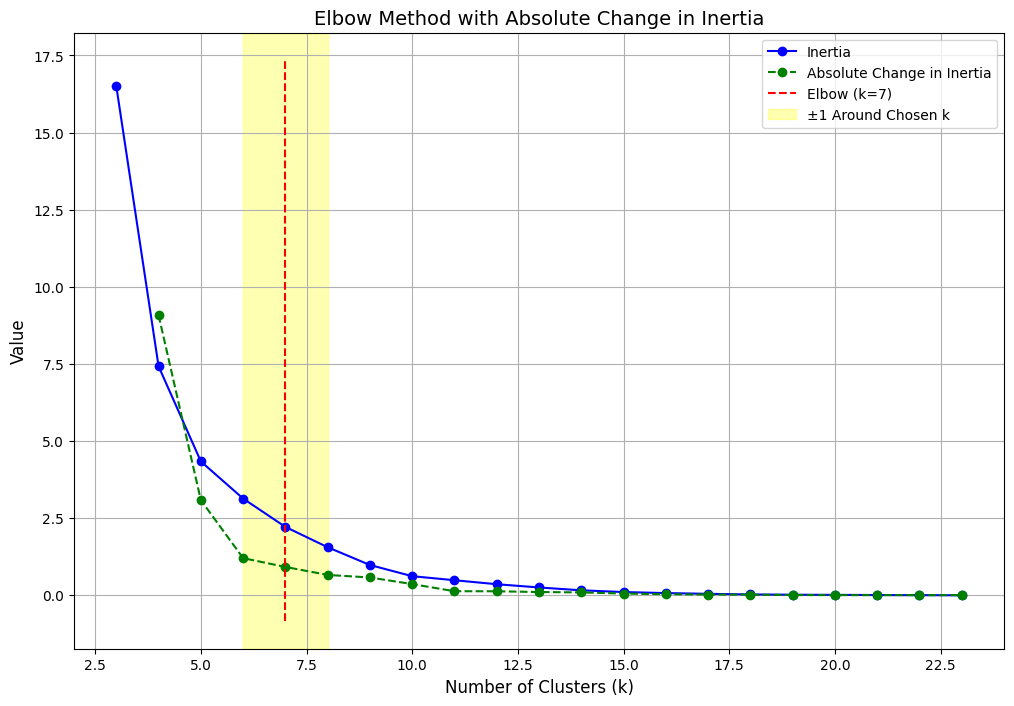

Processing random sample of size 24 (iteration 1)...
Fetching a random sample of 24 rows from the database...
Random sample of 24 rows fetched successfully.
List of cities in the random sample:
['Indianapolis', 'Zandvoort', 'Suzuka', 'Portimão', 'Montmeló', 'Sochi', 'Mexico City', 'Jeddah', 'Spielberg', 'Imola', 'Lusail', 'Riyadh', 'Kuala Terengganu', 'Sepang', 'São Paulo', 'Shanghai', 'Vancouver', 'Silverstone', 'Valencia', 'Chicago', 'Miami', 'Nürburg', 'Stavelot', 'Melbourne']


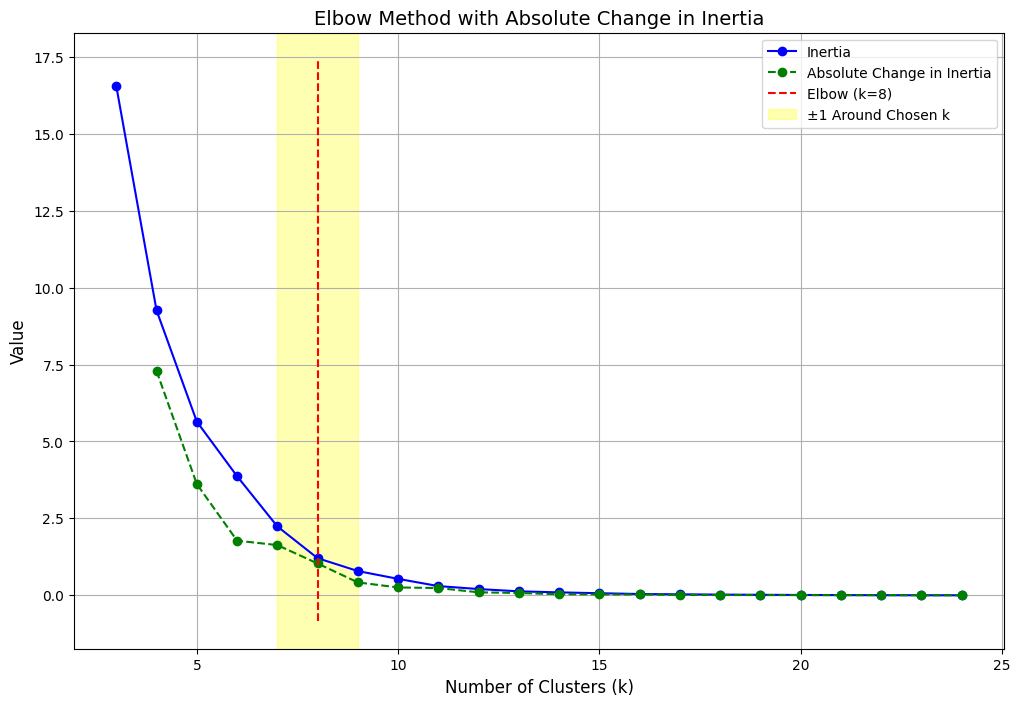

Processing random sample of size 25 (iteration 1)...
Fetching a random sample of 25 rows from the database...
Random sample of 25 rows fetched successfully.
List of cities in the random sample:
['Baku', 'Hockenheim', 'Chicago', 'Nürburg', 'Auckland', 'Silverstone', 'Melbourne', 'Abu Dhabi', 'Sochi', 'Jeddah', 'Oslo', 'Valencia', 'Montmeló', 'Mexico City', 'Sakhir', 'Buenos Aires', 'Montreal', 'Singapore', 'São Paulo', 'Istanbul', 'Suzuka', 'Portimão', 'Spielberg', 'Shanghai', 'Las Vegas']


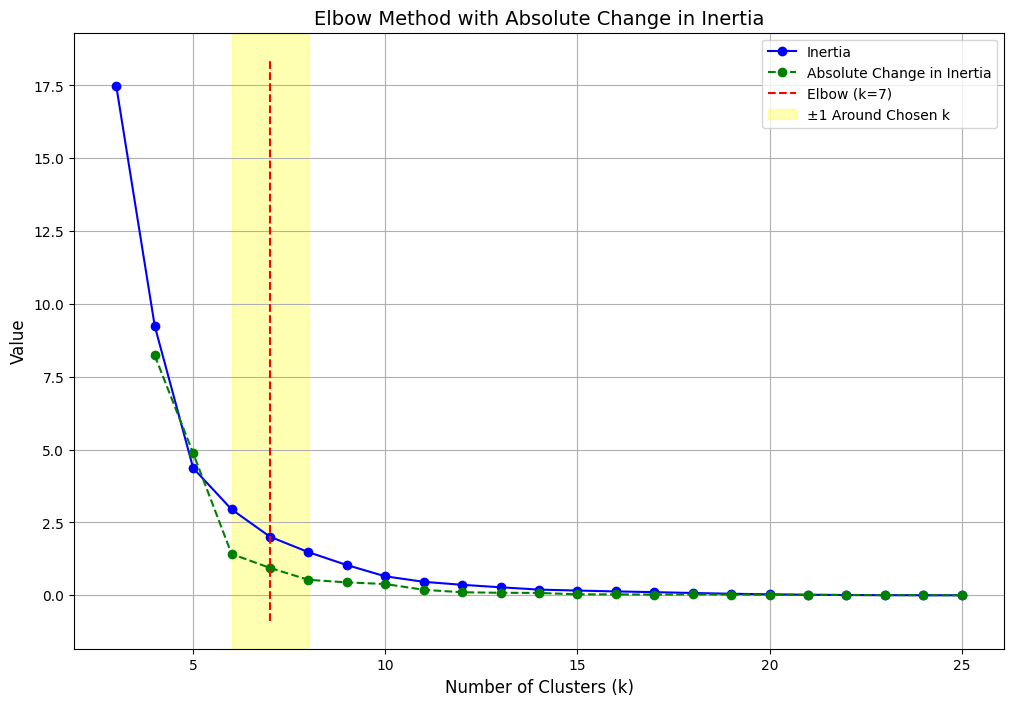

In [29]:
n = [15,16,17,18,19,20,21,22,23,24,25]
size = 1
for i in n:
    for j in range(size):
        print(f"Processing random sample of size {i} (iteration {j+1})...")
        random_sample_df = get_random_sample(i, verbose=True)
        print("List of cities in the random sample:")
        print(random_sample_df['city'].tolist())
        clusterized_df = clusterize_circuits(df=random_sample_df, opt_k_img_verbose=True, fig_verbose=True)
        